# Radial Density plotting for Endothelial to Hematopoietic transition analysis

### Author: Alvaro Regano (alvaro.regano@gmail.com)

In this project I looked into the Aorta Gonad Mesonephros (AGM) of E10.5 mouse embryos under various conditions.

In order to look at the Differences in the cell populations that comprised the AGM, I made used of a Radial Density plot where I could represent all 4 cell populations side by side. 

In this notebook I describe how I visualized the date following DEG analysis using DeSeq2

## Setup

### Import Modules


In [3]:
import os
import sys
import logging
import random
from collections import defaultdict
import math
import openpyxl

import anndata as ad
import scanpy as sc

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from adjustText import adjust_text
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
import seaborn as sns
from anndata import AnnData
from mudata import MuData
from patsy import dmatrix
from scipy.stats import combine_pvalues

logger = logging.getLogger(__name__)


Cannot load rpy2: No module named 'anndata2ri'


## Define Functions

`seed_everything` gives random seed values for the scattering of plot points (genes) in the Radial Density plot.

`jitter` introduces a spread that can be regulated for the scattering of plots

`rade_plot` produces the radial density plot where various arguments can be inputed to color genes of interest, give p values thresholds and so on.


In [33]:
def seed_everything(seed=42):
    """ "
    Seed everything.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

# jitter dots to give random spread to RaDe plot
def jitter(x, spread=0.6):
    # random.seed(42)
    return x + random.uniform(0, spread) - (spread / 2)

def rade_plot(
    input_df,
    point_size=5, # Size of dots
    point_alpha=1, # Transparency of labelled dots
    point_alpha_background = 0.1, # transparency on non labelled dots
    max_y=3, # Length of y ratio (Log2FC)
    jitter_spread=0.9, # spread of markers along the x axis, done randomly
    color_map="viridis", # color map or padj values (not used by me)
    max_log10_pval=5, # max p-valu for colormap legend
    log_cutoff_label=2.5,  # cutoff for labels in log form
    random_order=True,
    n_top=None, # number of top markers to labelled, ranked by log2FC and then padj, with a cutoff
    label_fc_cutoff=0, # cutoff label for fc values
    label_sig_cutoff=0.05, # cutoff lable for padj
    which_label=None, # if you want to label specific genes
    label_size=10, # label size
    sig_col="padj", # name of the column containing the padj values
    fc_col="log2FoldChange", # name of the column containing the fc values
    log_10=True,
    fig_size=10, # size of figure
    fig=None, 
    title_fontsize=25, 
    id_label_fontsize=20,
    order_id = None, # order of the ids used in the radial plot, in vector form
    order_splits = None, # order of the conditions used in the radial plot, in vector form
    color_label_goi = False, # True, False or None, if you want to have your goi labelled in color instead of text
    linewidth_size=1, # size of linewidth use for indicating if markers pass a established padj threshold
):
    input_df = input_df.copy()
    unique_splits = list(set(input_df["Up_In"].tolist()))
    if order_splits == None:
        unique_splits
    else:
        unique_splits = [unique_splits[i] for i in order_splits]
    unique_ids = sorted(list(set(input_df["ID"].tolist())))
    input_df["orig_sig"] = input_df[sig_col]

    if order_id == None:
        unique_ids
    else:
        unique_ids = [unique_ids[i] for i in order_id]
    step_size = round(360 / len(unique_ids))

    ids = {k: math.radians(v * step_size) for v, k in enumerate(unique_ids)}
    input_df["num_id"] = input_df["ID"].apply(lambda x: ids[x])
    input_df["jitter"] = input_df["num_id"].apply(
        lambda x: jitter(x, spread=jitter_spread)
    )

    if log_10:
        input_df[sig_col] = np.log10(input_df[sig_col]).copy()
        input_df.loc[(input_df[sig_col] == -0.0), sig_col] = +0

        highest_value = np.max(
            input_df[sig_col].to_numpy()[np.nonzero(input_df[sig_col].to_numpy())]
        )

        input_df[sig_col] = -np.nan_to_num(
            input_df[sig_col], copy=True, nan=0, posinf=highest_value, neginf=0
        )

        input_df[sig_col] = np.where(input_df[sig_col] == -0, +0, input_df[sig_col])

    
    if random_order:
        seed_everything(seed=42)
        input_df = input_df.sample(frac=1).reset_index(drop=True)
    else:
        input_df = input_df.sort_values(sig_col, ascending=True)
    

    if fig is None:
        fig, axs = plt.subplots(
            1,
            len(unique_splits),
            figsize=(fig_size, fig_size),
            squeeze=True,
            sharey=True,
            sharex=True,
            facecolor="white",
            edgecolor="#04253a",
            subplot_kw={"projection": "polar"},
            gridspec_kw={"wspace": 0.5, "right": 1},
        )
    else:
        axs = fig.axes

    for i, split in enumerate(unique_splits):
        if len(unique_splits)>1:
            ax = axs[i]
        else:
            ax=axs
        data = input_df[input_df["Up_In"] == split].copy()

        if n_top is not None or label_sig_cutoff is not None:
         if n_top is  not None and label_sig_cutoff is not None:
          top_n = (
            data.loc[
                (data[fc_col] >= label_fc_cutoff) & (data["orig_sig"] <= label_sig_cutoff),
                :,
            ]
            .sort_values(by=[fc_col, "orig_sig"], ascending=[False, True], axis=0)
            .groupby("ID")
            .head(n_top)
          )
        
          data_subset_n = top_n

        if which_label is not None:
         data_subset = data.loc[(data["Gene"].isin(which_label)) & (data[fc_col] >= label_fc_cutoff)]

        
        if (label_sig_cutoff is None and color_label_goi is False):
            ax.set_title(f"Upregulated in {split}", pad=25, fontsize=title_fontsize)
            plot = ax.scatter(
                data=data,
                x="jitter",
                y=fc_col,
                s=point_size,
                c=sig_col,
                cmap=color_map,
                alpha=point_alpha,
                linewidths=0,
                edgecolors=None,
                vmax=max_log10_pval,
            )

        # Design plot to color code specific genes in the RaDe plot

        elif (color_label_goi is True and label_sig_cutoff is None):
            from random import randint
            color_goi = []
            n = len(which_label)
            color_palette = sns.color_palette("husl", n)

            def rgb_to_hex(rgb):
                # Convert RGB tuple to hexadecimal color representation
                return '#%02x%02x%02x' % (int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
            
            color_goi = [rgb_to_hex(color) for color in color_palette]

            color_gene_dict = {}

            for gene in which_label:
                if gene not in color_gene_dict:
                   color_index = len(color_gene_dict) % len(color_goi)
                   color_gene_dict[gene] = color_goi[color_index]
            
            default_color = 'lightgray'
            color_goi_sorted = [color_gene_dict.get(gene, default_color) for gene in data["Gene"]]

            transparency_selected = []
            for color in color_goi_sorted:
                if color is 'lightgray':
                    transparency_selected.append(point_alpha_background)
                else:
                    transparency_selected.append(point_alpha)
            
            sorted_data = sorted(zip(data["jitter"], data['Gene'],data[fc_col], color_goi_sorted, transparency_selected), key=lambda item: (item[3]), reverse=True)
            df_data_original = pd.DataFrame(sorted_data, columns=['jitter','Gene','y', 'colors', 'preferences'])
            df_data = df_data_original.copy()
            if label_sig_cutoff is not None:
             for i, value in enumerate(df_data['y']):
                if value <= label_fc_cutoff:
                    df_data.iloc[i,3] = 'lightgray'
                    df_data.iloc[i,4] = point_alpha_background


            alpha = df_data['preferences']

            ax.set_title(f"Upregulated in {split}", pad=25, fontsize=title_fontsize)
            plot = ax.scatter(
                data = df_data,
                x='jitter',
                y='y',
                s=point_size,
                c='colors',
                # cmap=color_map,
                alpha=alpha,
                linewidths=0,
                edgecolors=None,
                vmax=max_log10_pval,
            )

    # label padj threshold dots red (less than) and light gray (more than)

        elif (label_sig_cutoff is not None and color_label_goi is False):
            color = []
            for value in data["orig_sig"]:
                if value <= label_sig_cutoff:
                    color.append('red')
                else:
                    color.append('lightgray')
            
            ax.set_title(f"Upregulated in {split}", pad=25, fontsize=title_fontsize)
            plot = ax.scatter(
                data=data,
                x="jitter",
                y=fc_col,
                s=point_size,
                c=color,
                # cmap=color_map,
                alpha=point_alpha,
                linewidths=0,
                edgecolors=None,
                vmax=max_log10_pval,
            )

        else:

            from random import randint
            color_goi = []
            n = len(which_label)
            color_palette = sns.color_palette("husl", n)

            def rgb_to_hex(rgb):
                # Convert RGB tuple to hexadecimal color representation
                return '#%02x%02x%02x' % (int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))
            
            color_goi = [rgb_to_hex(color) for color in color_palette]

            color_gene_dict = {}

            for gene in which_label:
                if gene not in color_gene_dict:
                   color_index = len(color_gene_dict) % len(color_goi)
                   color_gene_dict[gene] = color_goi[color_index]
            
            default_color = 'lightgray'
            color_goi_sorted = [color_gene_dict.get(gene, default_color) for gene in data["Gene"]]
            transparency_selected = []
            for color in color_goi_sorted:
                if color is 'lightgray':
                    transparency_selected.append(point_alpha_background)
                else:
                    transparency_selected.append(point_alpha)

            color_edge = []
            for value in data["orig_sig"]:
                if value <= label_sig_cutoff:
                    color_edge.append('red')
                else:
                    color_edge.append('lightgray')
            
            sorted_data = sorted(zip(data['jitter'], data['Gene'],data[fc_col], color_goi_sorted, transparency_selected, color_edge), key=lambda item: (item[3]), reverse=True)

            df_data_original = pd.DataFrame(sorted_data, columns=['jitter','Gene','y', 'colors', 'preferences', 'edgecolor'])
            df_data = df_data_original.copy()

            if label_sig_cutoff is not None:
             for i, value in enumerate(df_data['y']):
                if value <= label_fc_cutoff:
                    df_data.iloc[i,3] = 'lightgray'
                    df_data.iloc[i,4] = point_alpha_background

               
            alpha = df_data['preferences']
            
            
            ax.set_title(f"Upregulated in {split}", pad=25, fontsize=title_fontsize)
            plot = ax.scatter(
                data=df_data,
                x='jitter',
                y='y',
                s=point_size,
                c="colors",
                # cmap=color_map,
                alpha=alpha,
                linewidths=linewidth_size,
                edgecolors='edgecolor',
                vmax=max_log10_pval,
            )


        tick_pos = [x + math.radians(step_size / 2) for x in ids.values()]
        label_pos = [x for x in ids.values()]

        ax.set_xticks(tick_pos)
        ax.set_rticks(range(0, max_y, 1))
        ax.set_rmax(max_y + 1)
        ax.set_rlim(bottom=0, top=max_y)
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
        ax.xaxis.set_minor_locator(ticker.FixedLocator(label_pos))
        ax.xaxis.set_tick_params(pad=20, which="minor", labelsize=id_label_fontsize)
        ax.xaxis.set_minor_formatter(ticker.FixedFormatter(list(ids.keys())))   
        ax.set_ylabel(fc_col, labelpad=-930, rotation=270, fontsize = 20)    
        ax.set_yticklabels(range(0, max_y, 1), fontsize = 20)
        ax.set_aspect(1.0 / ax.get_data_ratio())


    # Label text for repel

        if which_label or n_top is not None:

         if color_label_goi is False and n_top is None:
          texts = [
             ax.text(
                 data_subset["jitter"].iloc[i],
                 data_subset[fc_col].iloc[i],
                 data_subset["Gene"].iloc[i],
                 color="#000000",
                 fontsize=label_size,
             )
              for i in range(0, data_subset.shape[0])
              if data_subset[fc_col].iloc[i] > label_fc_cutoff
         ]
          adjust_text(
            texts,
            x=data_subset["jitter"].tolist(),
            y=data_subset[fc_col].tolist(),
            ax=ax,
            # expand_text=(1.0, 1.0),  # Adjust these values as needed
            # force_points=(0.5, 0.5),  # Reduce the force on points if necessary
            # force_text=(0.5, 0.5),    # Reduce the force on text if necessary
            # expand_points=(1.0, 1.0),  # Adjust these values as needed
            # precision=0.001,
            # lim=10000000,
             expand=(1.0, 1.0),
            # expand_align=(1.5, 1.5),
            # autoalign="xy",
            arrowprops=dict(arrowstyle="-", color="black", lw=1),
         )
         
         elif n_top is not None and color_label_goi is True:
          texts = [
            ax.text(
                data_subset_n["jitter"].iloc[i],
                data_subset_n[fc_col].iloc[i],
                data_subset_n["Gene"].iloc[i],
                color="#000000",
                fontsize=label_size,
            )
            for i in range(0, data_subset_n.shape[0])
            if data_subset_n[fc_col].iloc[i] > label_fc_cutoff
          ]
          adjust_text(
            texts,
            x=data_subset["jitter"].tolist(),
            y=data_subset[fc_col].tolist(),
            ax=ax,
            # expand_text=(0.5, 0.5),  # Adjust these values as needed
            # force_points=(0.5, 0.5),  # Reduce the force on points if necessary
            # force_text=(0.5, 0.5),    # Reduce the force on text if necessary
            # expand_points=(1.0, 1.0),  # Adjust these values as needed
            # precision=0.001,
            # lim=10000000,
            # expand_align=(1.5, 1.5),
            expand=(1.0, 1.0),
            # autoalign="xy",
            arrowprops=dict(arrowstyle="-", color="black", lw=1),
          )

         elif n_top is not None and color_label_goi is False:
          
        #   In case there have been no indication of goi 

          try:
           combined_dataset = pd.concat((data_subset, data_subset_n), axis = 0)  
          except:
             combined_dataset = data_subset_n
        
          texts = [
            ax.text(
                combined_dataset["jitter"].iloc[i],
                combined_dataset[fc_col].iloc[i],
                combined_dataset["Gene"].iloc[i],
                color="#000000",
                fontsize=label_size,
            )
            for i in range(0, combined_dataset.shape[0])
            if combined_dataset[fc_col].iloc[i] > label_fc_cutoff
          ]
          adjust_text(
            texts,
            x=combined_dataset["jitter"].tolist(),
            y=combined_dataset[fc_col].tolist(),
            ax=ax,
            # expand_text=(1.0, 1.0),  # Adjust these values as needed
            # force_points=(0.5, 0.5),  # Reduce the force on points if necessary
            # force_text=(0.5, 0.5),    # Reduce the force on text if necessary
            # expand_points=(1.0, 1.0),  # Adjust these values as needed
            # precision=0.001,
            # lim=10000000,
            # expand_align=(1.5, 1.5),
            # autoalign="xy",
            expand=(1.0, 1.0),
            arrowprops=dict(arrowstyle="-", color="black", lw=1),
          )
        
         else:
          ax.text([])
        
    # Colorbar for padj value gradient

    if label_sig_cutoff is None and color_label_goi is False:
        main_cbar = fig.colorbar(
         plot,
         ax=axs,
         shrink=0.15,
         location="right",
         label="-log10(p.adj.)",
         anchor=(0, 0.3),
         drawedges=False,
        )

        main_cbar.outline.set_edgecolor("black")
        main_cbar.ax.tick_params(
            color="black",
            direction="inout",
            labelcolor="black",
            length=5,
            size=8,
            which="both",
            axis="y",
        )
        main_cbar.set_label("-log10(p.adj.)", fontsize=25, color="black")
        main_cbar.ax.tick_params(labelsize=20)

    elif color_label_goi is True:

    # Legend for color coded labels

        legend_values_unordered = list(set(color_gene_dict.keys()))

        index_values = {value: index for index, value in enumerate(which_label)}
        legend_values = sorted(legend_values_unordered, key=lambda x: index_values[x])
        
        legend_elements = []
        for value in legend_values:
            color = color_gene_dict[value]
            legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=25, label= value))

        legend = plt.legend(handles=legend_elements, title='Labelled Genes', loc='lower left', fontsize=30, bbox_to_anchor=(-0.36, 0))
        legend.get_title().set_fontsize(25)

        
      
    plt.margins(x=0)
    plt.tight_layout()
    plt.close()
    return fig

<>:167: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:246: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:167: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:246: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/tmp/ipykernel_12675/277783573.py:167: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if color is 'lightgray':
/tmp/ipykernel_12675/277783573.py:246: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if color is 'lightgray':


In [9]:
os.getcwd()

'/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/Tables/Final_DEG_RaDe_Tables'

## Load Data

The data was contained in an excel spreadsheet, where each worksheet represented a DEG analysis containing the different cell populations of Control vs Condition.

The dataset contained five different conditions: Notch1 GOF, Notch1LOF, Jag1LOF, Mfng GOF, Nmyc LOF. In this example I portray NMycLOF vs Control

In [36]:
# Going back from the plot directory

# os.chdir('../Tables/Final_DEG_RaDe_Tables/')

os.chdir('../../../Tables/Final_DEG_RaDe_Tables/')

# Final RaDe with fixed padj values

cond = ["Notch1 GOF", "Notch1LOF", "Jag1LOF", "Mfng GOF", "Nmyc LOF"]
rade_df = pd.read_excel('DEG_RaDe_per_cluster&condition_pseudocount_1_DESeq2_log2FC_0.25_min.pct_0.xlsx', sheet_name=cond[4])
rade_df.drop(columns=['p_val', 'avg_log2FC', 'pct_in', 'pct_out', 'rank'], inplace=True)

rade_df.head()

,Gene,padj_BH,padj_Bonferroni,ID,log2FoldChange,Up_In
0,Rpl26,0.009928,0.009928,Aorta Endothelium,0.939723,Control
1,Tpm1,0.017530,0.035059,Aorta Endothelium,0.883862,Nmyc LOF
2,Zbtb20,0.030057,0.090172,Aorta Endothelium,0.764784,Nmyc LOF
3,Plxdc2,0.061258,0.245031,Aorta Endothelium,1.070248,Nmyc LOF
4,Ext1,0.061258,0.295365,Aorta Endothelium,0.648237,Nmyc LOF


# Remove Arterial ECs ID

The DEG analysis contained 5 cell populations. We decided on removing the Arterial EC population as we concluded it did not belong to the AGM but to the Intersomitic Vessels lining around the AGM instead

In [41]:
rade_df = rade_df[rade_df["ID"] != "Arterial ECs"]

rade_df["ID"].unique()

array(['Aorta Endothelium', 'Pre-HE', 'HE', 'IAC'], dtype=object)

## Produce plot Directories

In [12]:
# Create directories for plotting

dirs = ['1.CtlTie2vNotch1GOF', '2.CtlVEQvNotch1LOF', '3.CtlVEQvJag1LOF', '4.CtlTie2vMfngGOF', '5.CtlTie2vNMycLOF']

os.chdir('../../Plots/Paper/')

for i,dir in enumerate(dirs):
    os.makedirs(dir, exist_ok = True)

In [15]:
# Locate Folders where to put plots:

dirs = ['1.CtlTie2vNotch1GOF', '2.CtlVEQvNotch1LOF', '3.CtlVEQvJag1LOF', '4.CtlTie2vMfngGOF', '5.CtlTie2vNMycLOF']


# First time

# os.chdir(''.join(['../../Plots/Paper/', dir[4]]))

# Or

os.chdir(dirs[0])

# Afterwards

# os.chdir(''.join(['../', dirs[0]]))

os.getcwd()

'/media/alvaro/HDD Almacenamiento/PhD/Bioinformatics/scAGM_Embryos/Plots/Paper/1.CtlTie2vNotch1GOF'

## Select padj to represent in the RaDe plot

The DEG analysis was performed using DESeq2 and padj values were computed using the Bonferroni and Benamini-Hochberg approaches. I represented the data using the padj BH adjustment, selected here below.

In [45]:
# Select which padj to go with

rade_df["padj"] = rade_df["padj_BH"]

# rade_df["padj"] = rade_df["padj_Bonferroni"]


In [32]:
rade_df.head()

,Gene,padj_BH,padj_Bonferroni,ID,log2FoldChange,Up_In,padj
0,Rpl26,0.009928,0.009928,Aorta Endothelium,0.939723,Control,0.009928
1,Tpm1,0.017530,0.035059,Aorta Endothelium,0.883862,Nmyc LOF,0.017530
2,Zbtb20,0.030057,0.090172,Aorta Endothelium,0.764784,Nmyc LOF,0.030057
3,Plxdc2,0.061258,0.245031,Aorta Endothelium,1.070248,Nmyc LOF,0.061258
4,Ext1,0.061258,0.295365,Aorta Endothelium,0.648237,Nmyc LOF,0.061258


## Reduce max values to a fixed log2FC threshold

Extreme values were set to a log2FC of 6 as they were already defined as extreme outliers

In [43]:
# Change gene values to a max threshold of 5

goi = "Mycn"

goi_df = rade_df.loc[rade_df['Gene'] == goi]

log2FC = 5.9

for i,val in goi_df.iterrows():
    if val['log2FoldChange'] > log2FC:
        rade_df.loc[i, 'log2FoldChange'] = log2FC



## Radial Density plotting

In the work I presented I used RaDe with 4 cell populations, setting a padj threshold of <0.05 and circling in red those genes that passed the threshold. I color labelled  12 genes of interest (goi) along all 4 cell populations.

/tmp/ipykernel_12675/277783573.py:274: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmax' will be ignored
  plot = ax.scatter(
/tmp/ipykernel_12675/277783573.py:274: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmax' will be ignored
  plot = ax.scatter(
/tmp/ipykernel_12675/277783573.py:452: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


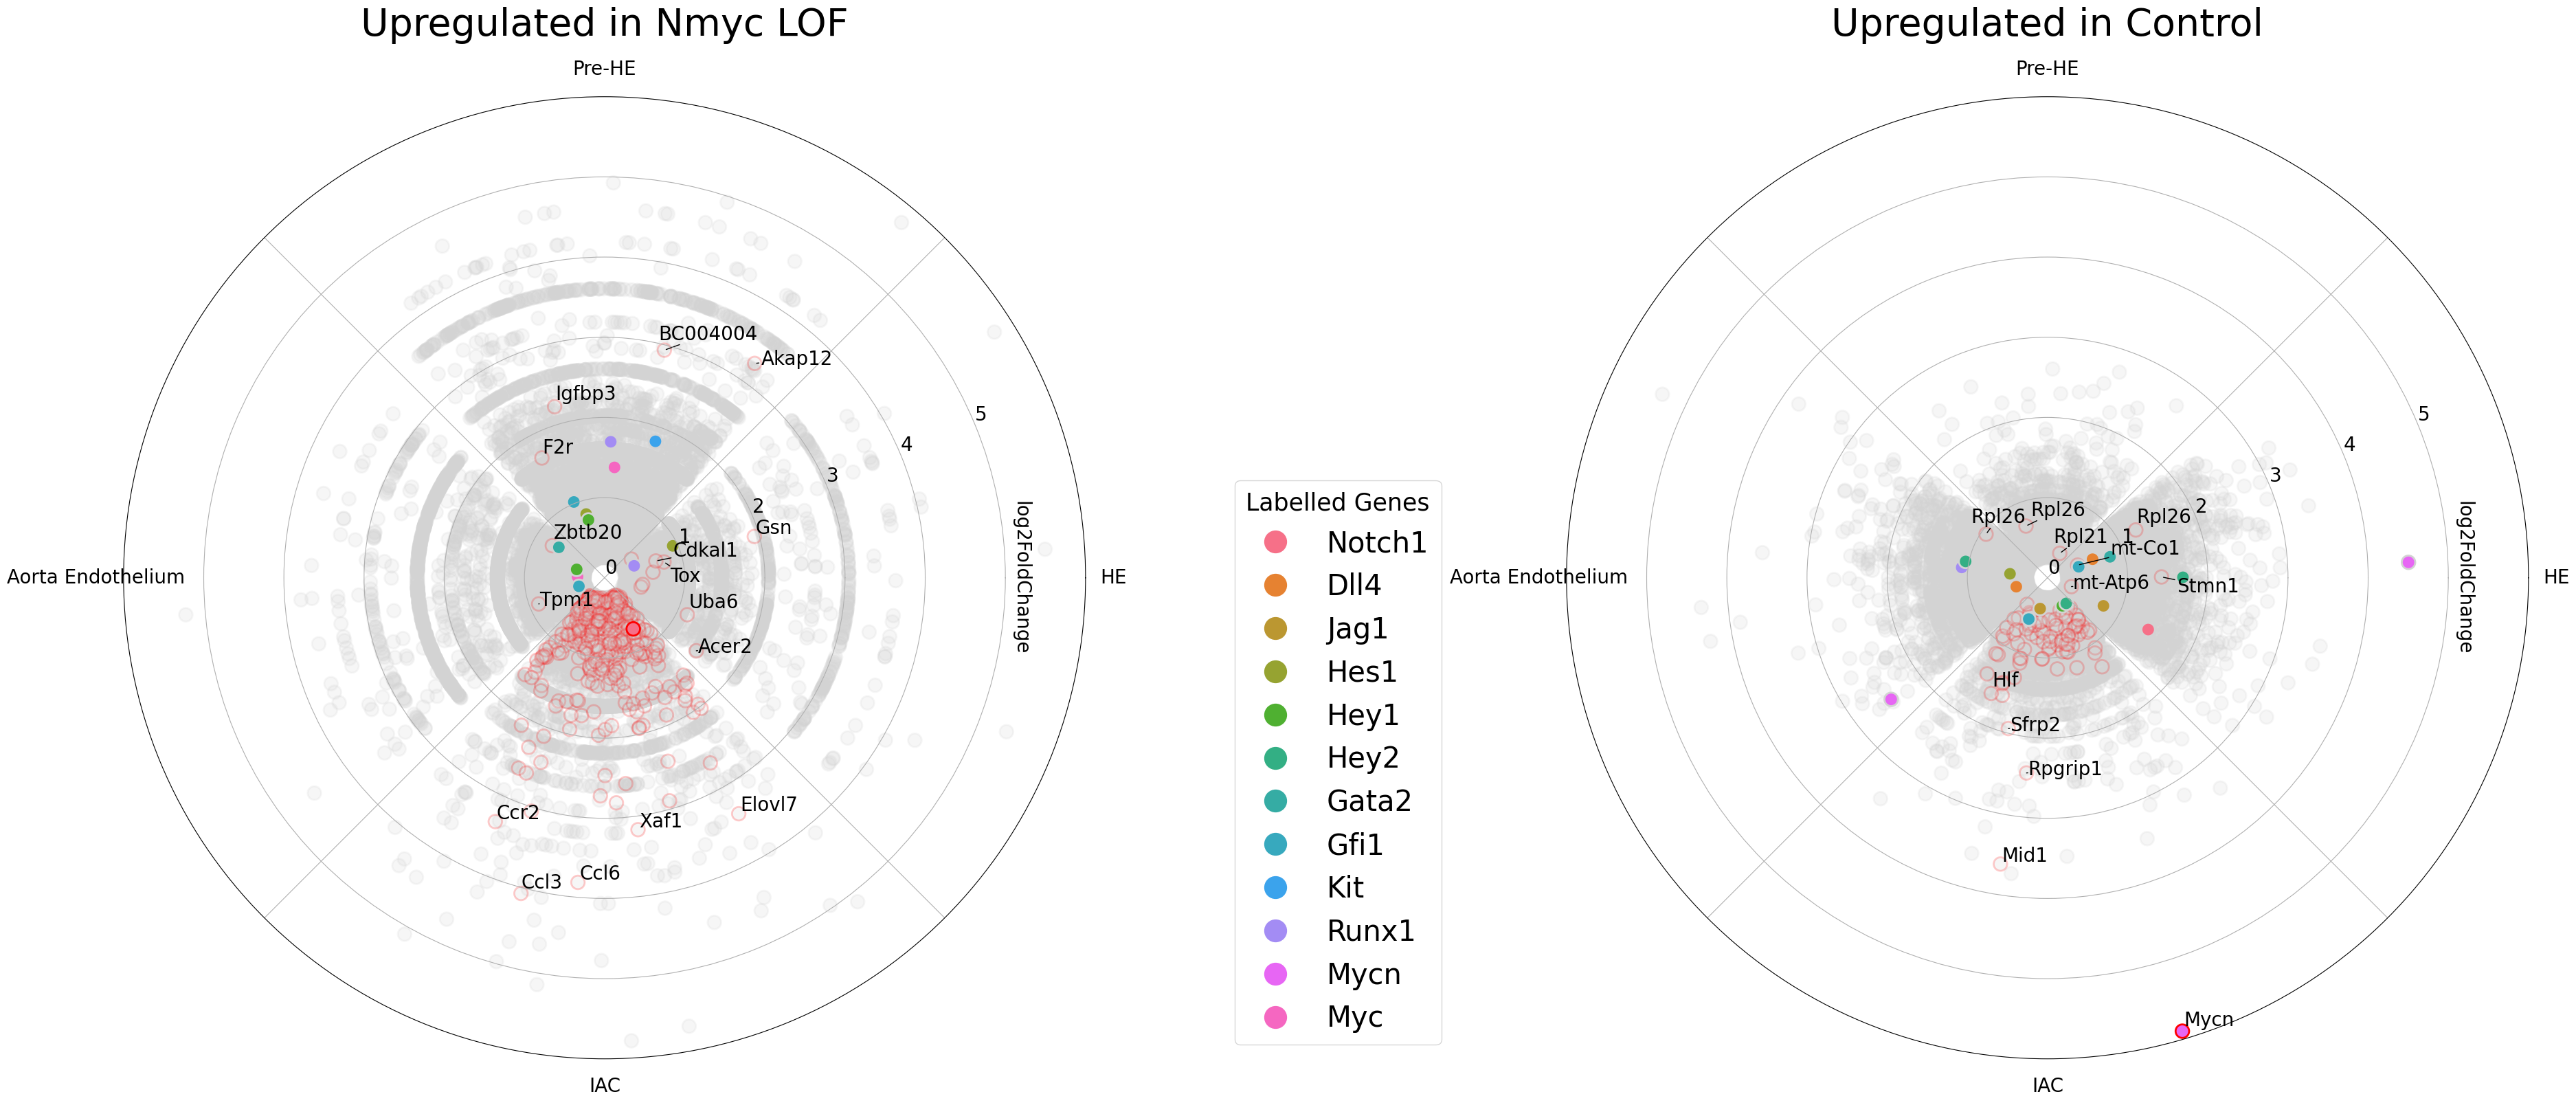

In [52]:
goi=["Notch1", "Dll4", "Jag1", "Hes1", "Hey1", "Hey2", "Gata2",
      "Gfi1", "Kit", "Runx1",  "Mycn", "Myc"]

Figure = rade_plot(input_df=rade_df,
          point_size=200,
          point_alpha=1,
          point_alpha_background=0.2,
          label_size=20,
          jitter_spread=1.4, # when RaDe is segmented into 4
          max_y=6,
          label_fc_cutoff=0.25,
          max_log10_pval=5,
          color_map="spring",
          random_order=False,
          which_label=goi,
          log_cutoff_label=0.5,
          n_top=5,
          fig_size=40,
          label_sig_cutoff=0.05,
          title_fontsize=40,
          order_id = [1,3,0,2],
          color_label_goi = True,
          linewidth_size=2,
          order_splits=[1,0]

          
    )

Figure

## Save plots

In [223]:
Figure.savefig(''.join([cond[4], "_RaDe_wilcoxauc_color_label_goi_sorted_pseudocount_1_logFC_0.25_BH_padj_topn10.pdf"]), format="pdf", bbox_inches="tight")

Figure.savefig(''.join([cond[4], "_RaDe_wilcoxauc_color_label_goi_sorted_pseudocount_1_logFC_0.25_BH_padj_topn10.jpeg"]), format="jpeg", bbox_inches="tight")


In [225]:
Figure.savefig(''.join([cond[4], "_RaDe_wilcoxauc_color_label_goi_sorted_pseudocount_1_logFC_0.25_BH_padj_topn5.pdf"]), format="pdf", bbox_inches="tight")

Figure.savefig(''.join([cond[4], "_RaDe_wilcoxauc_color_label_goi_sorted_pseudocount_1_logFC_0.25_BH_padj_topn5.jpeg"]), format="jpeg", bbox_inches="tight")

## Session Info

In [50]:
import session_info

session_info.show()